In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pysepm
import IPython.display as ipd
import pandas as pd

Measures:
* PESQ &rarr; Perceptual evaluation of speech quality, using the wide-band (from 0.5 to 4.5).
* STOI % &rarr; Short-Time Objective Intelligibility (from 0 to 100).
* CSIG &rarr; Mean opinion score (MOS) prediction of the signal distortion attending only to the speech signal (from 1 to 5).
* CBAK &rarr; MOS prediction of the intrusiveness of background noise (from 1 to 5).
* COVL &rarr; MOS prediction of the overall effect (from 1 to 5).
* SSNR &rarr; Segmental SNR (from 0 to inf).

In [2]:
pesqs = []
#uno, dos, tres = [], [], []
count = 0
for line in open('/opt/kaldi/egs/Signal-denoising-in-the-wild/data/denoising_test.scp'):
    clean_path, noisy_path = line.rstrip().split()
    clean, fs = librosa.load(clean_path, sr= 16000)
    noisy, fs = librosa.load(noisy_path, sr = 16000)
    pesqs.append(pysepm.stoi(clean, noisy, fs))
    #tmp = pysepm.composite(clean, noisy, fs)
    #uno.append(tmp[0])
    #dos.append(tmp[1])
    #tres.append(tmp[2])
    count += 1
    if count % 200 == 0:
        print("{} done..".format(count))


print(np.mean(pesqs))
#print(np.mean(uno), np.mean(dos), np.mean(tres))

200 done..
400 done..
600 done..
800 done..
0.9210623795360344


In [5]:
clean, fs = librosa.load(clean_path, sr= 16000)
noisy, fs = librosa.load(noisy_path, sr = 16000)

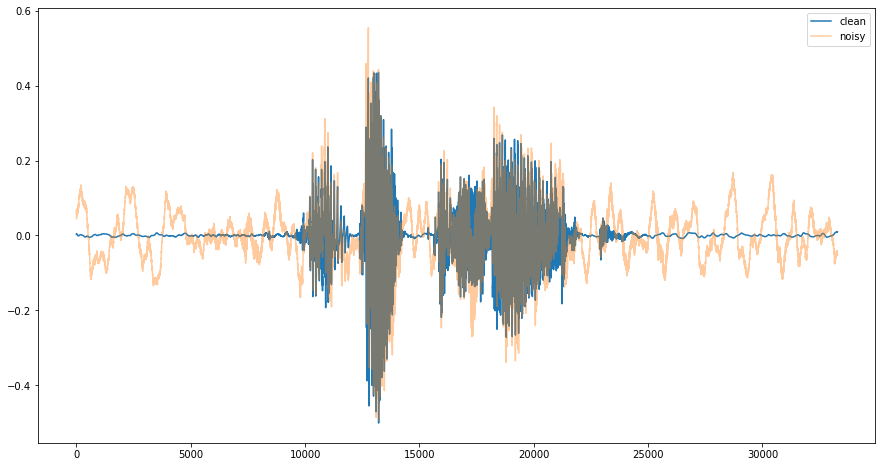

In [12]:
plt.figure(figsize = (15, 8))
plt.plot(clean, label = 'clean')
plt.plot(noisy, label = 'noisy', alpha = .4)
plt.legend()

In [16]:
pysepm.pesq(clean, noisy, fs)[1]

1.6231114864349365

In [27]:
pysepm.fwSNRseg(clean, noisy, fs)

5.921577051068924

In [23]:
pysepm.stoi(clean, noisy, fs)

0.9464705599848037

In [24]:
pysepm.composite(clean, noisy, fs)

(2.9466960172992014, 1.7938655903418346, 2.239961088943264)

In [ ]:
pysepm.qualityMeasures.composite()

In [4]:
CSIG = [3.35, 3.23, 0.0]
CBAK = [2.44, 2.68, 0.0]
COVL = [2.63, 2.67, 0.0]
PESQ = [1.97, 2.22, 0.0]
SSNR = [1.68, 5.07, 0.0]

In [7]:
pd.DataFrame(zip(CSIG, CBAK, COVL, PESQ, SSNR), columns = ['CSIG', 'CBAK', 'COVL', 'PESQ', 'SSNR'],
             index=['Noisy', 'Wiener', 'Model'])

,CSIG,CBAK,COVL,PESQ,SSNR
Noisy,3.35,2.44,2.63,1.97,1.68
Wiener,3.23,2.68,2.67,2.22,5.07
Model,0.00,0.00,0.00,0.00,0.00
